In [ ]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import date as current_date
from fedot_ind.api.utils.checkers_collections import ApiConfigCheck
from fedot_ind.core.architecture.pipelines.abstract_pipeline import ApiTemplate
from fedot_ind.core.repository.config_repository import DEFAULT_COMPUTE_CONFIG, DEFAULT_TSF_AUTOML_CONFIG, \
    DEFAULT_TSF_LEARNING_CONFIG, DEFAULT_TSF_INDUSTRIAL_CONFIG
from fedot_ind.core.repository.constanst_repository import M4_FORECASTING_BENCH_SMALL, M4_FORECASTING_BENCH_SMALL_DAILY, \
    M4_FORECASTING_BENCH_SMALL_MONTHLY, M4_FORECASTING_BENCH_SMALL_QUARTERLY, M4_FORECASTING_BENCH_SMALL_WEEKLY, \
    M4_FORECASTING_BENCH_SMALL_YEARLY, M4_FORECASTING_LENGTH, M4_SEASONALITY

2025-02-25 04:09:17,498 - PyTorch version 2.2.2 available.


In [ ]:
DATASET_NAME = 'M4'
EVAL = False

In [4]:
benchmark_dict = {
                  'Daily': M4_FORECASTING_BENCH_SMALL_DAILY, 
                  'Monthly': M4_FORECASTING_BENCH_SMALL_MONTHLY, 
                  'Quarterly': M4_FORECASTING_BENCH_SMALL_QUARTERLY, 
                  'Weekly': M4_FORECASTING_BENCH_SMALL_WEEKLY, 
                  'Yearly': M4_FORECASTING_BENCH_SMALL_YEARLY
                  }

In [ ]:
if EVAL:
    def get_benchmark_setup(benchmark):
        print(benchmark)
        DEEPAR_LEARNING_PARAMS = {'epochs': 200, 'lr': 0.001, 'device': 'cpu'}
        TCN_LEARNING_PARAMS = {'epochs': 200, 'num_layers': 4, 'dropout': 0.01, 'num_filters': 4, 'kernel_size': M4_FORECASTING_LENGTH[benchmark[0][0]], 'weight_norm': True}
        ETS_LEARNING_PARAMS = {'seasonal': None, 'seasonal_periods': M4_SEASONALITY[benchmark[0][0]]}
        model_to_compare = [
            {}, 
            {0: [('ets', ETS_LEARNING_PARAMS)]}, 
            {0: [('tcn_model', TCN_LEARNING_PARAMS)]},
            {0: [('deepar_model', DEEPAR_LEARNING_PARAMS)]}
            ]
        model_name = ['industrial', 'ets', 'tcn', 'deepar']
        finetune_existed_model = [False, True, True, True]
        BENCHMARK = f'{DATASET_NAME}_{benchmark[0]}'
        BENCHMARK_PARAMS = {'experiment_date': current_date.today().isoformat(),
                            'metadata': M4_FORECASTING_LENGTH,
                            'datasets': benchmark[1],
                            'model_to_compare': (model_to_compare, model_name, finetune_existed_model)}
        
        BENCHMARK_CONFIG = {'task': 'ts_forecasting',
                        'task_params': {'forecast_length': M4_FORECASTING_LENGTH[benchmark[0][0]]},
                        'timeout': 2,
                        'n_workers': 4,
                        'threads_per_worker': 2,
                        'with_tuning': True,
                        'logging_level': 20
                        }
        
        return BENCHMARK, BENCHMARK_PARAMS, BENCHMARK_CONFIG

    API_CONFIG = {'industrial_config': DEFAULT_TSF_INDUSTRIAL_CONFIG,
                'automl_config': DEFAULT_TSF_AUTOML_CONFIG,
                'learning_config': DEFAULT_TSF_LEARNING_CONFIG,
                'compute_config': DEFAULT_COMPUTE_CONFIG}
    config_agent = ApiConfigCheck()

    if __name__ == "__main__":
        for benchmark in benchmark_dict.items():
            BENCHMARK, BENCHMARK_PARAMS, BENCHMARK_CONFIG = get_benchmark_setup(benchmark)
            UPD_API_CONFIG = config_agent.update_config_with_kwargs(config_to_update=API_CONFIG,
                                                                    **BENCHMARK_CONFIG)
            config_agent.compare_configs(API_CONFIG, UPD_API_CONFIG)
            api_agent = ApiTemplate(api_config=UPD_API_CONFIG, metric_list=('rmse', 'mae', 'mdae', 'smape', 'mase', 'mdase', 'mape'))
            api_agent.evaluate_benchmark(benchmark_name=BENCHMARK,
                                        benchmark_params=BENCHMARK_PARAMS)

In [ ]:
model_list = ['industrial', 'ets', 'tcn']

result_dict = dict()
for benchmark in benchmark_dict.items():
    input_folder = os.path.join('./benchmark_results', f'2025-02-25_{DATASET_NAME}_{benchmark[0]}')
    dataset_dict = dict()
    for dataset in benchmark[1]:
        model_dict = dict()
        for model in model_list:
            try:
                model_dict[model] = np.load(os.path.join(input_folder, model, dataset, 'results.npy'),allow_pickle='TRUE').item()
            except:
                model_dict[model] = {}
        dataset_dict[dataset] = model_dict
    result_dict[benchmark[0]] = dataset_dict

In [190]:
metrics_df = pd.DataFrame()
for benchmark_result in result_dict.items():    
    dataset_df = pd.DataFrame()
    for dataset_result in benchmark_result[1].items(): 
        for model_result in dataset_result[1].items():
            try:
                model_df = pd.DataFrame(model_result[1]['metrics'])
                model_df['model'] = model_result[0]
                model_df['dataset'] = dataset_result[0]
                model_df['time'] = model_result[1]['time']
                model_df['length'] = len(model_result[1]['train_data'])
                model_df['speed'] = model_df['length'] / model_df['time'] 
                model_df['benchmark'] = benchmark_result[0]
            except:
                model_df = pd.DataFrame()
            dataset_df = pd.concat([dataset_df, model_df])
    metrics_df = pd.concat([metrics_df, dataset_df])
metrics_df

,rmse,mae,mdae,mase,mdase,mape,smape,model,dataset,time,length,speed,benchmark
0,68.204,59.452,81.167,4.893,8.989,5.619,5.421,industrial,D1002,133.225322,1066,8.001482,Daily
0,58.901,50.531,62.440,4.159,6.915,4.775,4.630,ets,D1002,6.154568,1066,173.204691,Daily
0,46.312,39.489,45.425,3.250,5.030,3.737,3.645,tcn,D1002,39.197228,1066,27.195801,Daily
0,31.940,27.406,32.952,1.544,2.474,1.510,1.511,industrial,D1019,107.359068,4089,38.087141,Daily
0,38.792,33.461,37.366,1.886,2.805,1.841,1.843,ets,D1019,37.797918,4089,108.180561,Daily
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,929.279,856.333,919.735,1.267,1.976,24.810,22.111,ets,Y13802,0.061003,38,622.922928,Yearly
0,6632.002,6502.156,6842.924,7.637,9.818,51.720,40.655,industrial,Y14055,137.854041,46,0.333686,Yearly
0,2447.502,1965.915,1657.978,2.309,2.379,16.062,14.232,ets,Y14055,0.057000,46,807.018651,Yearly
0,4011.234,3076.865,2895.585,2.298,4.391,20.026,23.926,industrial,Y14324,161.269854,45,0.279035,Yearly


In [191]:
metrics_df.groupby(['benchmark', 'dataset']).mean().round(2)

rmse       mae      mdae   mase         mdase   mape  \
benchmark dataset                                                             
Daily     D1002       57.81     49.82     63.01   4.10  6.980000e+00   4.71   
          D1019       34.18     29.32     29.43   1.65  2.210000e+00   1.62   
          D1032       98.36     92.34     88.72   4.36  5.880000e+00   8.91   
          D1101      178.40    158.06    164.36   1.98  2.920000e+00   3.33   
          D1104      306.11    281.12    260.97   3.62  4.550000e+00   2.20   
          D1124      238.71    206.99    196.70   2.40  3.120000e+00   2.36   
          D1162       33.76     27.08     23.29   1.51  2.040000e+00   2.13   
          D1170       59.19     52.56     41.51   3.33  3.850000e+00   4.11   
          D1204      303.29    284.75    306.48   4.20  6.560000e+00   1.98   
          D1219      389.72    359.38    390.58   7.16  1.149000e+01   2.41   
Monthly   M10641     597.99    536.97    539.25   1.30  1.500000e+00   5.04   
          M1080      315.38    291.98    305.58   1.79  1.950000e+00   3.54   
          M11230      71.39     65.61     70.19   1.59  1.900000e+00   3.83   
          M11654     287.76    239.76    218.78   1.40  1.460000e+00   4.90   
          M11779     109.75     93.90     82.21   1.21  1.370000e+00   2.05   
          M11806      98.75     84.57     83.96   2.49  2.950000e+00   3.35   
          M12209     195.75    165.72    137.54   0.75  8.400000e-01   3.96   
          M12241     264.67    212.66    172.72   0.94  1.010000e+00   2.29   
          M12422      69.33     62.71     59.29   1.77  1.980000e+00   2.73   
          M12452      92.64     79.78     74.48   1.46  1.490000e+00   3.12   
Quarterly Q10070     137.16    135.09    138.71   1.54  1.690000e+00   8.64   
          Q10262     842.43    749.27    738.59   1.09  1.480000e+00   8.20   
          Q10292     234.51    223.76    229.43   1.58  1.950000e+00  14.68   
          Q10466    1252.89   1102.07   1143.02   3.63  4.310000e+00  10.64   
          Q10598    1982.35   1758.98   1628.29   4.85  7.220000e+00  11.17   
          Q10665     470.04    407.88    453.33   1.61  2.390000e+00  15.16   
          Q1069      310.60    271.64    231.29   1.73  2.050000e+00   2.95   
          Q10743    1409.49   1161.46   1061.02   3.90  4.950000e+00  15.75   
          Q10800     521.96    470.35    487.91   0.99  1.240000e+00  24.72   
          Q10881     479.71    415.36    430.09   0.86  9.400000e-01   4.00   
Weekly    W10        377.46    336.19    395.84   5.70  1.782712e+18   6.10   
          W103       147.43    121.36     99.45   2.68  4.660000e+00   2.93   
          W105       108.47     92.41    100.83   4.49  1.133000e+01   1.02   
          W106        21.20     17.08     14.49   1.56  1.720000e+00   0.79   
          W107       525.20    495.66    537.88  11.00  2.404000e+01   2.04   
          W109       128.62    110.69    122.27   3.56  5.590000e+00   0.78   
          W110       243.69    231.37    235.35   4.96  6.000000e+00   3.09   
          W111        17.70     15.43     16.13   1.65  4.090000e+00   1.43   
          W113        39.43     32.09     28.91   0.47  6.000000e-01   4.40   
          W116       720.88    615.06    523.25   3.60  4.930000e+00   4.27   
Yearly    Y10907     207.25    154.62    107.80   2.47  1.800000e+00   8.57   
          Y10908    2050.72   1909.73   1867.13   4.48  5.660000e+00  14.89   
          Y11041     892.52    851.83    951.01   6.33  9.000000e+00  12.71   
          Y1107     4675.80   4639.65   4740.64  15.46  2.411000e+01  44.25   
          Y11106     395.69    366.44    366.60   4.53  5.160000e+00  13.58   
          Y11116    2796.72   2719.92   2500.17  10.83  1.659000e+01  23.13   
          Y11430   37368.79  25249.95  10679.04   3.70  1.187000e+01  59.44   
          Y13802    1095.75    939.70    931.01   1.39  2.000000e+00  28.62   
          Y14055    4539.75   4234.04   4250.45   4.97  6.100000e+00  33.

In [192]:
metrics_df[['model', 'benchmark', 'rmse', 'smape', 'mase', 'speed']].groupby(['benchmark', 'model']).mean().round(2)

rmse  smape  mase    speed
benchmark model                                     
Daily     ets           215.26   4.32  4.33    93.92
          industrial    173.68   3.34  3.55    24.04
          tcn           120.91   2.37  2.41    24.03
Monthly   ets           277.97   5.04  2.07  1046.49
          industrial    171.45   2.94  1.24     2.53
          tcn           181.60   2.71  1.09    28.24
Quarterly ets           924.45  13.13  2.63   622.85
          industrial    676.94  12.26  2.03     0.99
          tcn           752.49   9.35  1.92    25.08
Weekly    ets           228.14   2.95  4.93   105.44
          industrial    231.79   2.55  3.59    10.85
          tcn           189.82   2.51  3.51    26.37
Yearly    ets          5947.99  31.97  5.76   555.51
          industrial   6091.01  31.14  5.74     0.33
          tcn         17115.69  37.91  3.54    27.46

In [193]:
metrics_df[['model', 'benchmark', 'rmse', 'smape', 'mase', 'speed']].groupby(['model']).mean().round(2)

,rmse,smape,mase,speed
model,,,,
ets,1545.10,11.65,3.92,492.58
industrial,1468.97,10.44,3.23,7.75
tcn,1120.17,5.75,2.30,26.03


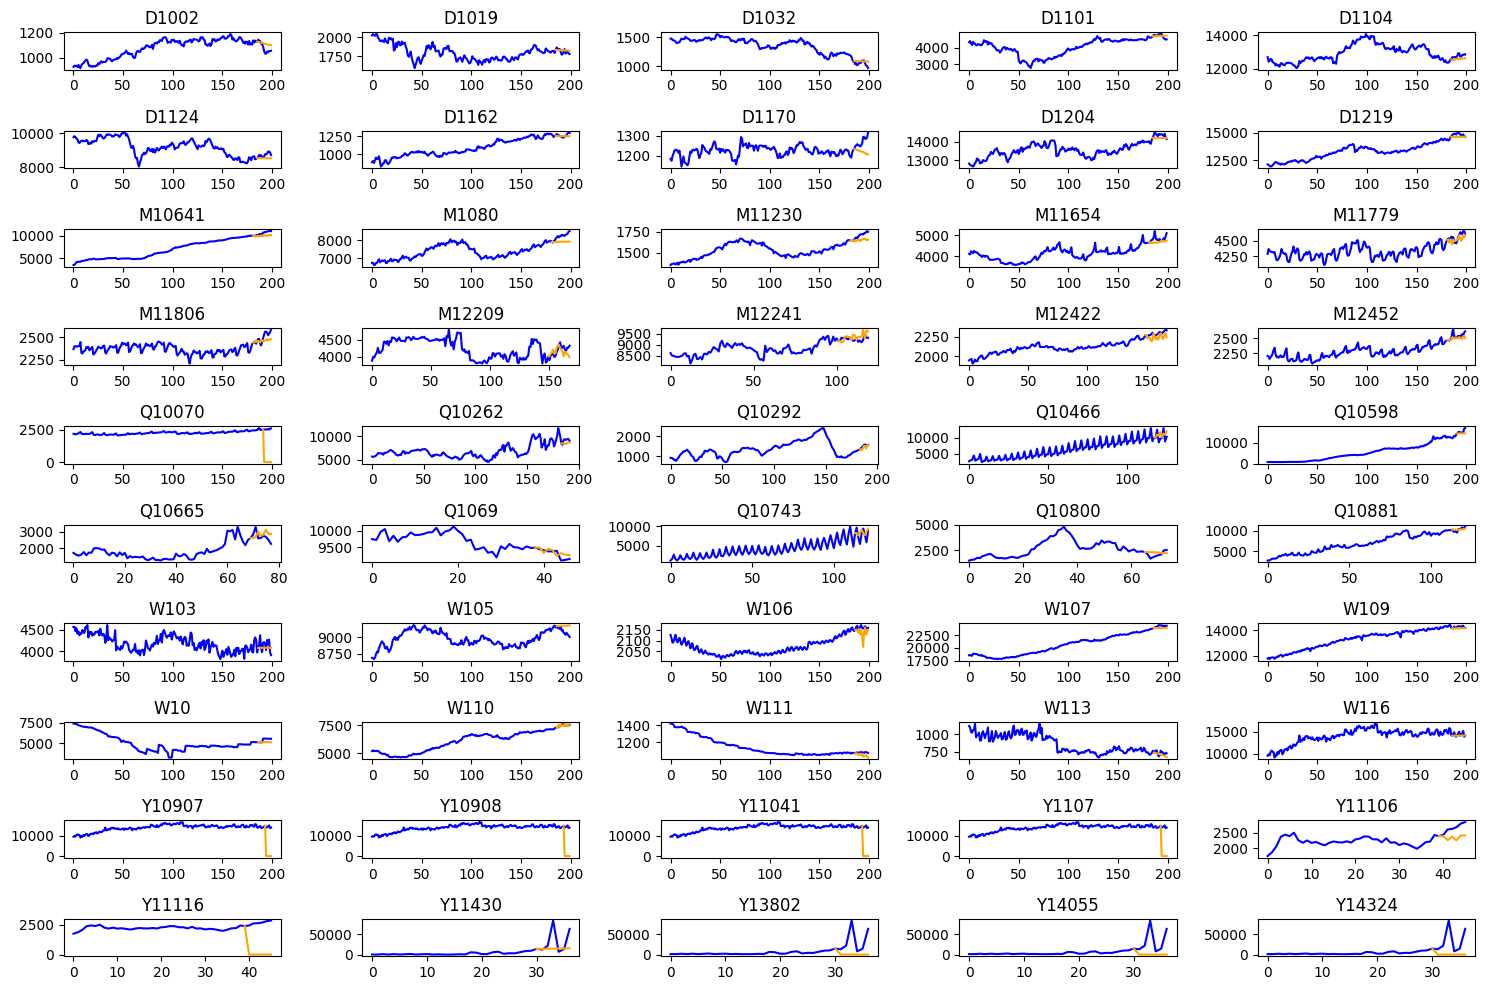

In [185]:
border = 200
fig, axes = plt.subplots(nrows=10, ncols=5, figsize=(15, 10), sharex=False, sharey=False)
axes = axes.flatten()
model_name = 'tcn'

idx = 0
for benchmark in benchmark_dict.items():
    horizon = M4_FORECASTING_LENGTH[benchmark[0][0]]
    for (label, data) in result_dict[benchmark[0]].items():
        if idx >= len(axes):
            break
        pred_dict = data[model_name]
        try:
            real_values = pred_dict['train_data']
            eigen = pred_dict['labels']
        except:
            eigen = np.zeros(shape=horizon)
        if len(real_values) > border:
            real_values = real_values[-border:]
        indicies = np.arange(real_values.shape[0])
        ax = axes[idx]
        ax.plot(real_values, label='Real values', color='blue')
        real_last_value = real_values[-horizon - 1]
        ax.plot(indicies[-horizon - 1:],
                np.insert(eigen, 0, real_last_value), label='Forecast', color='orange')
        ax.set_title(label)
        idx += 1
        
plt.tight_layout()
plt.show()

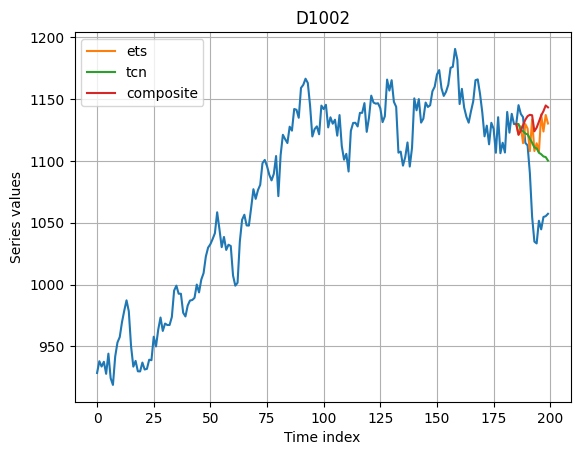

In [186]:
benchmark = 'Daily'
feature_name = 'D1002'
horizon = M4_FORECASTING_LENGTH[benchmark[0]]

model_list = ['ets', 'tcn', 'industrial']
border = 200
eigen_1 = result_dict[benchmark][feature_name][model_list[0]]['labels']
eigen_2 = result_dict[benchmark][feature_name][model_list[1]]['labels']
eigen_3 = result_dict[benchmark][feature_name][model_list[2]]['labels']
plt.close()
real_values = result_dict[benchmark][feature_name][model_list[0]]['train_data']

if len(real_values) > border:
        real_values = real_values[-border:]

real_values = real_values[-border:]
indicies = np.arange(real_values.shape[0])

plt.xlabel('Time index')
plt.ylabel('Series values')
plt.title(feature_name)
plt.plot(real_values)

for i, model in enumerate(model_list):
        model_list[i] = 'composite' if model == 'industrial' else model

real_last_value = real_values[-horizon - 1]
plt.plot(indicies[-horizon - 1:],
        np.insert(eigen_1, 0, real_last_value), label=f'{model_list[0]}')
plt.plot(indicies[-horizon - 1:],
        np.insert(eigen_2, 0, real_last_value), label=f'{model_list[1]}')
plt.plot(indicies[-horizon - 1:],
        np.insert(eigen_3, 0, real_last_value), label=f'{model_list[2]}')

plt.grid()
plt.legend()
plt.legend()

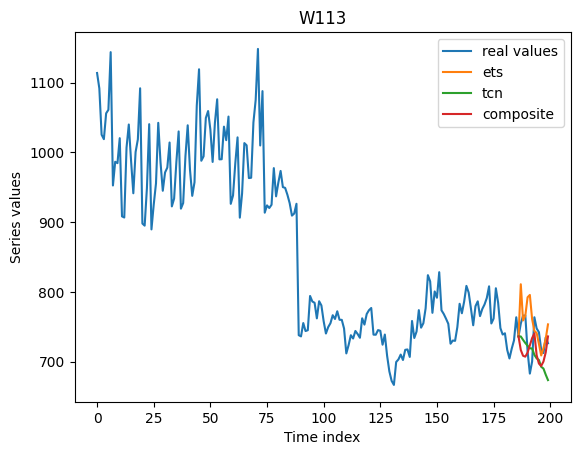

In [195]:
for benchmark in benchmark_dict.items():
        try:
                for feature_name in benchmark[1]:
                        model_list = ['ets', 'tcn', 'industrial']
                        horizon = M4_FORECASTING_LENGTH[benchmark[0][0]]
                        border = 200
                        eigen_1 = result_dict[benchmark[0]][feature_name][model_list[0]]['labels']
                        eigen_2 = result_dict[benchmark[0]][feature_name][model_list[1]]['labels']
                        eigen_3 = result_dict[benchmark[0]][feature_name][model_list[2]]['labels']
                        plt.close()
                        real_values = result_dict[benchmark[0]][feature_name][model_list[0]]['train_data']

                        if len(real_values) > border:
                                real_values = real_values[-border:]

                        real_values = real_values[-border:]
                        indicies = np.arange(real_values.shape[0])

                        plt.xlabel('Time index')
                        plt.ylabel('Series values')
                        plt.title(feature_name)
                        plt.plot(real_values, label='real values')

                        for i, model in enumerate(model_list):
                                model_list[i] = 'composite' if model == 'industrial' else model
                                
                        real_last_value = real_values[-horizon - 1]
                        plt.plot(indicies[-horizon - 1:],
                                np.insert(eigen_1, 0, real_last_value), label=f'{model_list[0]}')
                        plt.plot(indicies[-horizon - 1:],
                                np.insert(eigen_2, 0, real_last_value), label=f'{model_list[1]}')
                        plt.plot(indicies[-horizon - 1:],
                                np.insert(eigen_3, 0, real_last_value), label=f'{model_list[2]}')


                        plt.legend()
                        images_path = os.path.join('./benchmark_results', 'images', 'M4')
                        os.makedirs(images_path, exist_ok=True)
                        plt.savefig(os.path.join(images_path, f'{feature_name}.png'), dpi=fig.dpi)
        except:
                continue